In [1]:
import numpy as np
import torch as th
from utilities import *
from matplotlib import pyplot as plt
from time import time as get_time
np.set_printoptions(precision=4)
 
from force_engine import *
import mdtraj


## load data, get FES from metadynamics

In [2]:
dt = 0.004 # ps
traj = mdtraj.load('./alanine_depeptide/traj_4fs.dcd', top="./alanine_depeptide/alanine-dipeptide.pdb")
nframes = len(traj)
print('duration={}ns'.format(nframes * dt/1000))

phi = mdtraj.compute_phi(traj)[1].flatten() 
psi = mdtraj.compute_psi(traj)[1].flatten() 
v_phi = phi[1:] - phi[:-1]
v_phi[v_phi > np.pi] -= 2 * np.pi
v_phi[v_phi < -np.pi] += 2 * np.pi
v_phi = v_phi / dt   #1/fs

v_psi = psi[1:] - psi[:-1]
v_psi[v_psi > np.pi] -= 2 * np.pi
v_psi[v_psi < -np.pi] += 2 * np.pi
v_psi = v_psi/ dt   #1/fs

x_phi = phi[0] + np.cumsum(v_phi)*dt
x_psi = psi[0] + np.cumsum(v_psi)*dt

cv_x = np.concatenate([x_phi[:,None],x_psi[:,None]],-1)
cv_v = np.concatenate([v_phi[:,None],v_psi[:,None]],-1)
print('CV shape:', cv_x.shape)

np.save('alanine_depeptide/data/traj_4fs',cv_x)

duration=20.0ns
CV shape: (4999999, 2)


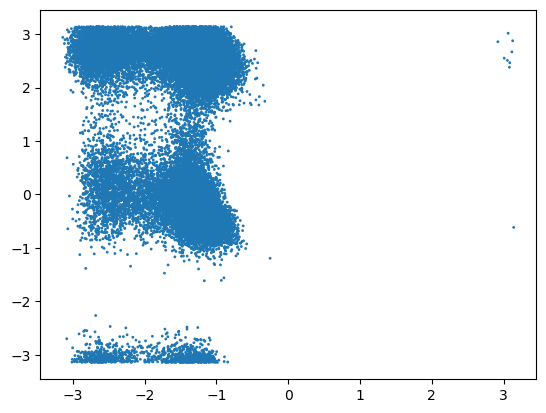

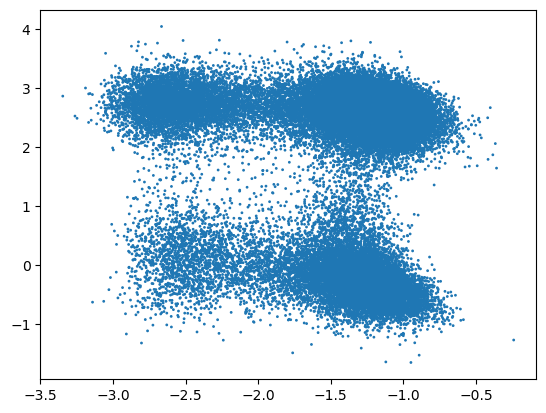

In [5]:
plt.scatter(phi[::100],psi[::100], np.ones_like(phi[::100]))
plt.figure()
plt.scatter(x_phi[::100],x_psi[::100], np.ones_like(x_phi[::100]))

## fit FES directly through interpolation

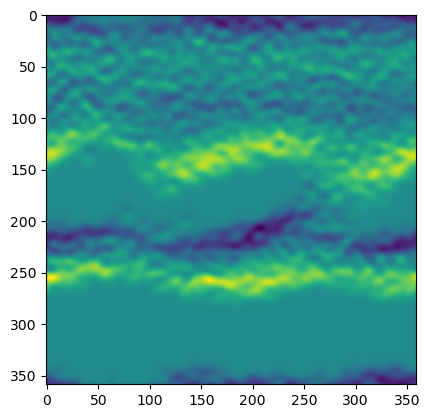

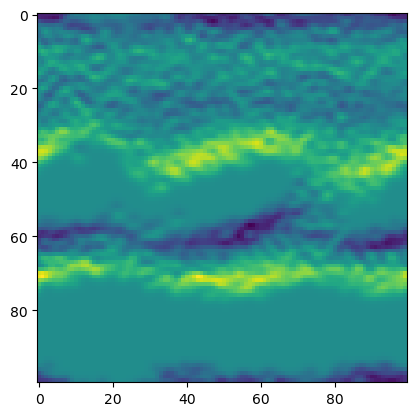

In [4]:
kbT2kjmol = 2.479
free_energy = np.load('./alanine_depeptide/free_energy.npy') #kJ/mol
free_energy -= free_energy.min()
free_energy /= kbT2kjmol  # in unit of kbT
free_energy = free_energy.T

def interpolate(m, shift):
    shift_x, shift_y = shift
    y0 = (1-shift_x) * m[0, 0] + shift_x * m[1,0]
    y1 = (1-shift_x) * m[0, 1] + shift_x * m[1,1]
    result = (1-shift_y)* y0 + shift_y * y1
    return result

def interpolated_energy(free_energy_table, phi_psi):
    fes = free_energy_table
    nx, ny = free_energy.shape
    ## the free energy repeats
    nx -= 1 
    ny -= 1
    rxy = (phi_psi+np.pi) / (2*np.pi)
    rxy = rxy - np.floor(rxy)
    rxy = rxy 
    lx = rxy[0] * nx
    ly = rxy[1] * ny   ## relative location between 0 and nx/ny
    
    base_idx_x = int(np.floor(lx)) % nx 
    base_idx_y = int(np.floor(ly)) % ny
    next_idx_x = (base_idx_x+1) % nx
    next_idx_y = (base_idx_y+1) % ny
    
    m = np.array([
        [fes[base_idx_x, base_idx_y], fes[base_idx_x, next_idx_y]],
        [fes[next_idx_x, base_idx_y], fes[next_idx_x, next_idx_y]]
    ])
    
    energy = interpolate(m, shift=[lx - base_idx_x, ly - base_idx_y])
    return energy
 
def get_force_func(free_energy, dx, dy):
    fes_gradx = ( np.roll(free_energy[:-1,:-1],-1,0) - np.roll(free_energy[:-1,:-1], 1, 0 )) / 2 / dx
    fes_grady = ( np.roll(free_energy[:-1,:-1],-1,1) - np.roll(free_energy[:-1,:-1], 1, 1 )) / 2 / dy    
    nx, ny = fes_gradx.shape
    def interpolated_force(phi_psi):
        rxy = (phi_psi+np.pi) / (2*np.pi)
        rxy = rxy - np.floor(rxy)
        rxy = rxy 
        lx = rxy[0] * nx
        ly = rxy[1] * ny   ## relative location between 0 and nx/ny

        base_idx_x = int(np.floor(lx)) % nx 
        base_idx_y = int(np.floor(ly)) % ny
        next_idx_x = (base_idx_x+1) % nx
        next_idx_y = (base_idx_y+1) % ny

        m = np.array([
            [fes_gradx[base_idx_x, base_idx_y], fes_gradx[base_idx_x, next_idx_y]],
            [fes_gradx[next_idx_x, base_idx_y], fes_gradx[next_idx_x, next_idx_y]]
        ])

        grad_x = interpolate(m, shift=[lx - base_idx_x, ly - base_idx_y])

        m = np.array([
            [fes_grady[base_idx_x, base_idx_y], fes_grady[base_idx_x, next_idx_y]],
            [fes_grady[next_idx_x, base_idx_y], fes_grady[next_idx_x, next_idx_y]]
        ])

        grad_y = interpolate(m, shift=[lx - base_idx_x, ly - base_idx_y])
        force = - np.array([grad_x, grad_y])
        return force
    return interpolated_force
    
xb = [-np.pi, np.pi]
yb = [-np.pi, np.pi]
nbins = [100, 100]
xbin = np.linspace(xb[0], xb[1], nbins[0]+1)[:-1]
xbin_ct = xbin + (xbin[1]-xbin[0])*0.5
ybin = np.linspace(yb[0], yb[1], nbins[1]+1)[:-1]
ybin_ct = ybin + (ybin[1]-ybin[0])*0.5


fes_pred = np.zeros((nbins[0], nbins[1]))
gradx_pred = np.zeros((nbins[0], nbins[1]))
grady_pred = np.zeros((nbins[0], nbins[1]))

force_func = get_force_func(free_energy, 1,1)
for idx_x, x in enumerate(xbin_ct):
    for idx_y, y in enumerate(ybin_ct):
        phi_psi =  np.array([x,y])
        fes_pred[idx_x, idx_y] = interpolated_energy(free_energy, phi_psi)
        grad = - force_func(phi_psi)
        gradx_pred[idx_x, idx_y] = grad[0]
        grady_pred[idx_x, idx_y] = grad[1]

gradx_ref = ( np.roll(free_energy[:-1,:-1],-1,0) - np.roll(free_energy[:-1,:-1], 1, 0 )) / 2 
plt.imshow(gradx_ref)
plt.figure()

plt.imshow(gradx_pred)

## plot heatmap of metadynamics FES

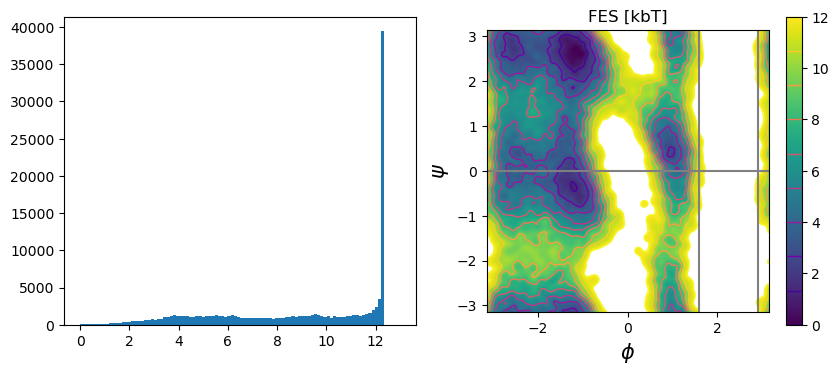

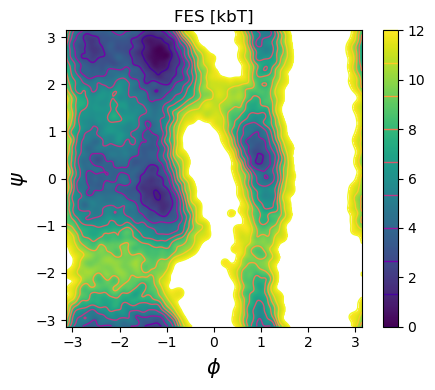

In [11]:
xb = [-np.pi, np.pi]
yb = [-np.pi, np.pi]
nbins = [360, 360]
xbin = np.linspace(xb[0], xb[1], nbins[0]+1)[:-1]
xbin_ct = xbin + (xbin[1]-xbin[0])*0.5
ybin = np.linspace(yb[0], yb[1], nbins[1]+1)[:-1]
ybin_ct = ybin + (ybin[1]-ybin[0])*0.5

# vmin, vmax = (0,free_energy.max()-0.0004)
vmin, vmax = (0,12)

level_set = np.linspace(vmin,vmax, 10)

alphas= (free_energy < vmax).astype(float)

fig,[ax1,ax] = plt.subplots(1,2, figsize=(10,4))
im = ax.imshow( free_energy.T, vmin=vmin, vmax=vmax,  alpha=alphas.T,
               aspect='equal', origin='lower', extent=xb+yb)
_cs = ax.contour(free_energy.T, levels=level_set , cmap='plasma',  linewidths=1,
           origin='lower', extent=xb+yb)
ax1.hist(free_energy.flatten(), 100, range=[0,13])
cbar = fig.colorbar(im, ax=ax)
cbar.add_lines(_cs)

# Add labels and title
ax.set_xlabel(r'$\phi$', fontsize=15)
ax.set_ylabel(r'$\psi$', fontsize=15)
ax.set_title('FES [kbT]')

ax.axhline(0. , color='grey')
ax.axvline(1.6 , color='grey')
ax.axvline(2.9 , color='grey')

free_energy.max()


fig, ax = plt.subplots(1,1, figsize=(5,4))
im = ax.imshow( free_energy.T, vmin=vmin, vmax=vmax,  alpha=alphas.T,
               aspect='equal', origin='lower', extent=xb+yb)
_cs = ax.contour(free_energy.T, levels=level_set , cmap='plasma',  linewidths=1,
           origin='lower', extent=xb+yb)
cbar = fig.colorbar(im, ax=ax)
cbar.add_lines(_cs)

# Add labels and title
ax.set_xlabel(r'$\phi$', fontsize=15)
ax.set_ylabel(r'$\psi$', fontsize=15)
ax.set_title('FES [kbT]')
plt.tight_layout()
plt.savefig('figures/AD_FES.png', dpi=300)

## Fourier fitting of the FES

In [53]:
dev = 'cuda' if th.cuda.is_available() else 'cpu'
## field parameters
Tx, Ty = (xb[1] - xb[0] , yb[1]-yb[0] ) 
nx, ny = [10,10]
nmodes = nx * ny
## train parameters
lr = 0.06
niter = 3000

## fourier modes
kx = np.linspace(0, 2*np.pi/Tx * nx, nx+1)[:nx]
ky = np.linspace(0, 2*np.pi/Ty * ny, ny+1)[:ny]
kxx, kyy = np.meshgrid(kx,ky, indexing='ij')
kxy = np.concatenate([kxx.reshape(-1,1), kyy.reshape(-1,1)], -1)
kxy = th.tensor(kxy, dtype=th.float,device=dev)

## sample points
rxx, ryy = np.meshgrid(xbin_ct, ybin_ct, indexing='ij')
rxy = np.concatenate([rxx.reshape(-1,1), ryy.reshape(-1,1)], -1)
rxy = th.tensor(rxy, dtype=th.float, device=dev)

## reference energy
fes_ref = th.tensor(free_energy.flatten(), dtype=th.float, device=dev)
fes_mask = (fes_ref < vmax).to(dtype=float)
# fes_ref = th.tensor(betaE.flatten(), dtype=th.float, device=dev)
# fes_mask = (fes_ref < vmax).to(dtype=float)

iter=0,loss=63.732356386746076
iter=300,loss=0.9753523708788991
iter=600,loss=0.6974098210863672
iter=900,loss=0.48732404605319407
iter=1200,loss=0.354681409578779
iter=1500,loss=0.2797084145822802
iter=1800,loss=0.24055888813220663
iter=2100,loss=0.22132906323414964
iter=2400,loss=0.2123677227594266
iter=2700,loss=0.20837065717740166


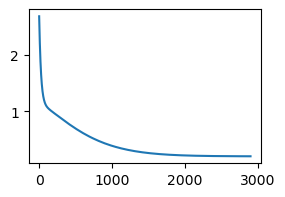

In [54]:
## coefficient of fourier modes
sinw_coef = th.tensor(np.zeros(nmodes), dtype=th.float, requires_grad=True,device=dev)
cosw_coef = th.tensor(np.zeros(nmodes), dtype=th.float, requires_grad=True,device=dev)
optimizer = th.optim.Adam([cosw_coef, sinw_coef], lr=lr)
scheduler = th.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.96)

loss_curve=[]

for idx in range(niter):
    fes_pred = fourier_nd_potential(cosw_coef, sinw_coef, kxy, rxy) # + harmonic_well(rxy, harmonic_k, harmonic_r0)
    loss = ((fes_pred - fes_ref)**2 * fes_mask).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    if (idx % (niter//10)) ==0:
        print('iter={},loss={}'.format(idx, th2np(loss)))
    if idx > 100:
        loss_curve.append(th2np(loss))

fig, ax = plt.subplots(1,1,figsize=(3,2))
ax.plot(loss_curve)

np.save('alanine_depeptide/GLE_data/fes_fourier_coef_sin.npy', th2np(sinw_coef))
np.save('alanine_depeptide/GLE_data/fes_fourier_coef_cos.npy', th2np(cosw_coef))
np.save('alanine_depeptide/GLE_data/fes_fourier_freq.npy', th2np(kxy))


## compare 

Text(0.5, 1.0, 'Fourier fitting')

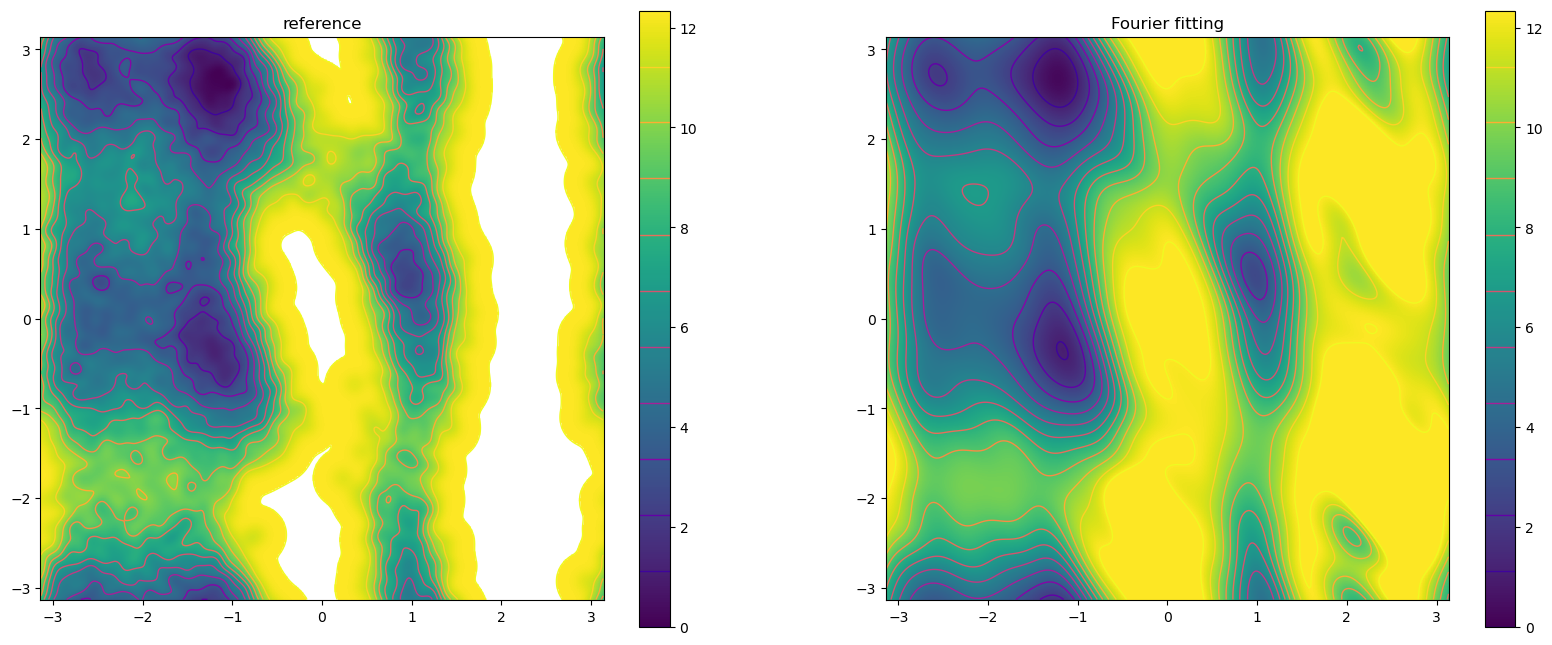

In [55]:
sinw_coef = np2th(np.load('alanine_depeptide/GLE_data/fes_fourier_coef_sin.npy' ))
cosw_coef = np2th(np.load('alanine_depeptide/GLE_data/fes_fourier_coef_cos.npy' ))
kxy = np2th(np.load('alanine_depeptide/GLE_data/fes_fourier_freq.npy'))
fes_pred = fourier_nd_potential(cosw_coef, sinw_coef, kxy, rxy)

fes_plot =  th2np(fes_pred).reshape(nbins[0],nbins[1]).T

level_set = np.linspace(0,vmax,12)
# level_set = [2,4,6,8,10,]

fig, [ax0,ax] = plt.subplots(1,2,figsize=(20,8))


im = ax0.imshow( free_energy.T, vmin=vmin, vmax=vmax, alpha=alphas.T,
               aspect='equal', origin='lower', extent=xb+yb)
_cs = ax0.contour(free_energy.T, levels=level_set , cmap='plasma',  linewidths=1,
           origin='lower', extent=xb+yb)
cbar = fig.colorbar(im, ax=ax0)
cbar.add_lines(_cs)
ax0.set_title('reference')

im = ax.imshow(fes_plot, vmin=vmin, vmax=vmax, # alpha=alphas.T,
             aspect='equal', origin='lower', extent=xb+yb)
_cs = ax.contour(fes_plot, levels=level_set , 
                 # colors='red',
                 cmap='plasma',  
                 linewidths=1, origin='lower', extent=xb+yb)

cbar = fig.colorbar(im, ax=ax)
cbar.add_lines(_cs)
ax.set_title('Fourier fitting')

 

# x_fine = th.tensor(np.linspace(xbin.min(), xbin.max(), 2000),dtype=th.float, device=dev)
# ax[1].plot(x_fine, th2np(pot(cosw_coef, sinw_coef, ws_torch, x_fine)))

## long traj


In [3]:
dt = 0.002 * 500 # ps
traj = mdtraj.load('/home/pinchenx/data.gpfs/AIGLE_scratch/continous_GLE/alanine_depeptide/data/traj_1us_dt1ps.dcd',
                   top="./alanine_depeptide/alanine-dipeptide.pdb")
nframes = len(traj)
print('duration={}ns'.format(nframes * dt/1000))

phi = mdtraj.compute_phi(traj)[1].flatten() 
psi = mdtraj.compute_psi(traj)[1].flatten() 
v_phi = phi[1:] - phi[:-1]
v_phi[v_phi > np.pi] -= 2 * np.pi
v_phi[v_phi < -np.pi] += 2 * np.pi
v_phi = v_phi / dt   #1/fs

v_psi = psi[1:] - psi[:-1]
v_psi[v_psi > np.pi] -= 2 * np.pi
v_psi[v_psi < -np.pi] += 2 * np.pi
v_psi = v_psi/ dt   #1/fs

x_phi = phi[0] + np.cumsum(v_phi)*dt
x_psi = psi[0] + np.cumsum(v_psi)*dt

cv_x = np.concatenate([x_phi[:,None],x_psi[:,None]],-1)
cv_v = np.concatenate([v_phi[:,None],v_psi[:,None]],-1)
print('CV shape:', cv_x.shape)

np.save('alanine_depeptide/data/traj_1ps',cv_x)

ndim = cv_x.shape[-1]
x_filter = cv_x[:,0] < 0

v2_left = cv_v[x_filter].std(0)
v2_right = cv_v[~x_filter].std(0)

print('mass (cv_1<0): ', v2_left)
print('mass (cv_1>0)', v2_right)

duration=1000.0ns
CV shape: (999999, 2)
mass (cv_1<0):  [0.3738 0.3631]
mass (cv_1>0) [0.2102 0.3969]


[0.     0.1385 0.1836 0.2204 0.2526 0.2805 0.3049 0.3268 0.3462 0.3637
 0.379  0.3925 0.4047 0.4158 0.4259 0.4348 0.4425 0.4498 0.4558 0.4618
 0.4669 0.4711 0.4751 0.4788 0.482  0.4852 0.4878 0.4901 0.4926 0.4941
 0.4961 0.4977 0.4993 0.5009 0.5023 0.5031 0.5048 0.5059 0.5062 0.5067
 0.5074 0.5079 0.5086 0.5092 0.5097 0.5102 0.5106 0.5111 0.5117 0.5122
 0.5128 0.5132 0.5134 0.5139 0.5139 0.514  0.5142 0.5145 0.5147 0.5145
 0.5146 0.5142 0.5139 0.5143 0.5144 0.5144 0.5146 0.5145 0.5147 0.5148
 0.5153 0.5157 0.5155 0.5154 0.515 ]


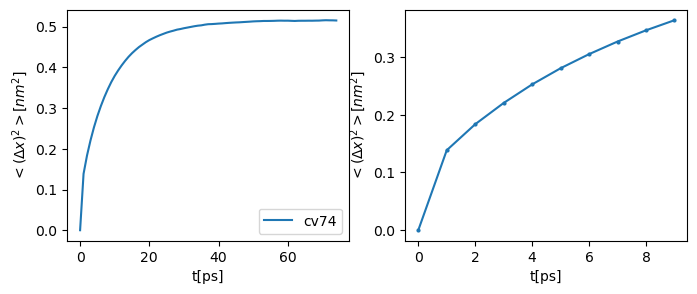

In [10]:
##diffusion
r2 = [0]
n=int(75/dt)
for idx in range(1,n):
    r2.append(((cv_x[idx:,0] - cv_x[:-idx,0])**2).mean())
r2 = np.array(r2)

## plot
fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].plot(np.arange(n)*dt, r2 ,label='cv{}'.format(idx))
ax[0].set_xlabel('t[ps]')
ax[0].set_ylabel('$<(\Delta x)^2>$[$nm^2$]')
ax[0].legend()
nn = 10
ax[1].plot(np.arange(nn)*dt, np.array(r2)[:nn], marker='o', markersize=2)
# ax[1].plot(np.arange(10)*dt, th2np(v2avg)[idx] * (np.arange(10)*dt)**2, linestyle='dashed' )
ax[1].set_xlabel('t[ps]')
ax[1].set_ylabel('$<(\Delta x)^2>$[$nm^2$]')

print(r2)

[[0.0000e+00 4.9031e-02 2.3586e-02 1.7072e-02 1.3138e-02 1.2099e-02
  1.7183e-02 4.6013e-02 3.2454e-01 5.0031e+00 8.7570e+01 1.7146e+02
  2.4132e+02 1.6158e+02 2.7040e+02 3.8918e+02 2.1367e+02 1.0580e+02
  1.0575e+02 9.3982e+01]
 [1.6426e+00 1.5576e+00 1.5122e+00 1.4740e+00 1.4701e+00 1.4666e+00
  1.4684e+00 1.4960e+00 1.6430e+00 5.8514e+00 1.3662e+02 8.9514e+01
  1.9643e+02 1.9664e+02 1.2886e+02 3.7676e+02 1.3885e+02 4.7517e+00
  5.1456e-01 0.0000e+00]]


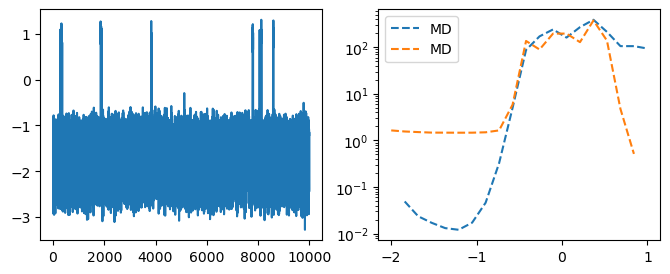

In [8]:
## mean first passage time
from mftp import calc_mfpt

n_points = 20
start=-2
end=1
milestones = np.linspace(start, end, n_points)
mfpt, mfpt_err = calc_mfpt( cv_x[:,0] , start=start, end=end, n_points=n_points, dt=dt/1000)

fig,ax=plt.subplots(1,2,figsize=(8,3))
ax[0].plot(cv_x[::100,0])
ax[1].semilogy(milestones[1:], mfpt[0][1:], linestyle='dashed', label='MD')
ax[1].semilogy(milestones[:-1], mfpt[1][:-1], linestyle='dashed', label='MD')
ax[1].legend()

print(mfpt)